<a href="https://colab.research.google.com/github/parament-integrator/examples/blob/master/qutip_bloch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using parament with qutip

In this example, we demonstrate how parament integrates with [qutip](https://qutip.org/).

We will simulate the evolution of a single qubit in the strong driving regime.


---




As a first step, we must prepare the environment. We install `parament` via `pip`.

The `NVCC_ARGS=\"-arch=compute_37\"` part instructs the compiler to target older GPUs as well, to maximize compatibility. This is necessary on Google Colab, as sometimes you will be assigned a fairly old Tesla K80 GPU that is not targeted by default.

In [3]:
!NVCC_ARGS="-arch=compute_37" pip install git+https://github.com/parament-integrator/parament#subdirectory=src
!pip install qutip

  Cloning https://github.com/parament-integrator/parament to /tmp/pip-req-build-ms1yjxam
  Running command git clone -q https://github.com/parament-integrator/parament /tmp/pip-req-build-ms1yjxam
  Created wheel for parament: filename=parament-0.1-py3-none-linux_x86_64.whl size=784110 sha256=fd9502c0c0e6732a2d60bb596ba863a1722fb09585c152ed050c617b94ad89ae
  Stored in directory: /tmp/pip-ephem-wheel-cache-v2jpl0om/wheels/30/d6/35/c1497ea3f67415126ff9dcde263bc6c57e63b2e80d38e99fc5
Successfully built parament
  Using cached https://files.pythonhosted.org/packages/81/26/24777cd6a939239c57467f59cacdd21a929eaf828da5c467a2a513cf4024/qutip-4.6.2-cp37-cp37m-manylinux2010_x86_64.whl


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import qutip as qu
import parament

In [5]:
f0 = 490e6
H0 = 2*np.pi*f0 * qu.sigmaz()/2

f1 = 2*100e6
H1 = 2*np.pi*f1 * qu.sigmax()/2

psi0 = qu.basis(2, 0)

In [6]:
runner = parament.Parament(precision='fp64')
runner.set_hamiltonian(H0, H1, use_magnus=True, quadrature_mode='simpson')

In [7]:
t_stop = 10e-9

N = 301
duration = np.linspace(0, t_stop, N+2)[2:]

xp = np.empty(N)
yp = np.empty(N)
zp = np.empty(N)

for i in range(N):
    ds = 2e-12
    t = np.arange(0, duration[i], ds)
    carr = np.sin(2*np.pi*f0*t)
    
    op2 = runner.equiprop(ds, carr[:-1])
    
    rho = op2 * psi0
    
    x_rot = qu.sigmax()
    meas_x = qu.expect(x_rot, rho)
    xp[i] = meas_x
    
    y_rot = qu.sigmay()
    meas_y = qu.expect(y_rot, rho)
    yp[i] = meas_y
    
    meas_z = qu.expect(qu.sigmaz(), rho)
    zp[i] = meas_z

In [8]:
xp = np.array(xp)
yp = np.array(yp)
zp = np.array(zp)

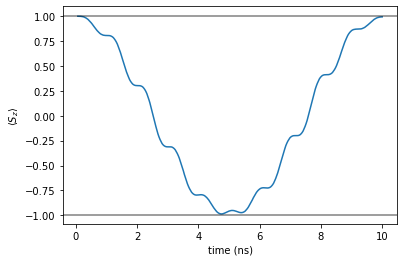

In [9]:
plt.figure()
plt.plot(duration*1e9, zp)
plt.axhline(1, c='k', alpha=0.5)
plt.axhline(-1, c='k', alpha=0.5)
plt.xlabel('time (ns)')
plt.ylabel(r'$\langle S_z\rangle$')
plt.show()


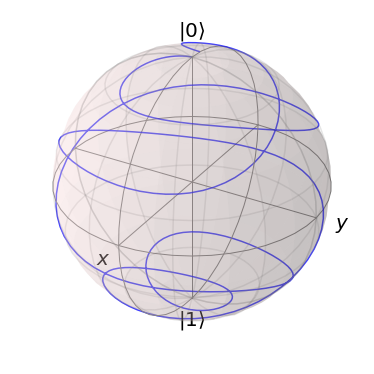

In [10]:
b = qu.Bloch()
b.add_points([xp, yp, zp], 'l')
b.render()